# 利用 gplearn 进行特征工程

featuretools有专门的 transfrom 类的特征处理方式，但是我在实际使用中没有使用，因为featuretool的思路是凡是能够进行特征变换的特征都要应用一遍，所以应用的模式基本上是生成大量的性能不强的特征，下一步必须进行严格的。

是时候试试gplearn这个库了。

gplearn是Python内最成熟的符号回归算法实现，作为一种一种监督学习方法，符号回归（symbolic regression）试图发现某种隐藏的数学公式，以此利用特征变量预测目标变量。

符号回归的具体实现方式是遗传算法（genetic algorithm）。一开始，一群天真而未经历选择的公式会被随机生成。此后的每一代中，最「合适」的公式们将被选中。随着迭代次数的增长，它们不断繁殖、变异、进化，从而不断逼近数据分布的真相。

- [汉语介绍](https://zhuanlan.zhihu.com/p/31185882)
- [官方文档](http://gplearn.readthedocs.io/en/stable/index.html)

当然我这里不是想尝试符号回归的机器学习方式，而是符号回归的机器学习方式提供了另外一种生成特征的思路，在库中通过Symbolic Transformer 类进行有关特征工程相关操作。

本文还是以 [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk)这个项目进行说明。

在手工特征工程中，我们会对两个或者多个特征进行一些 加减乘除的操作，来生成一些特征，希望能够生成一些
例如在[start-here-a-gentle-introduction](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction)的这篇kernel中，
根据领域的先验知识，对金额特征, 日期特征进行比值操作生成一些特征，这些特征经常能够提升验证集和测试集的分数，在模型中也有很高的重要程度。
```
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']
```


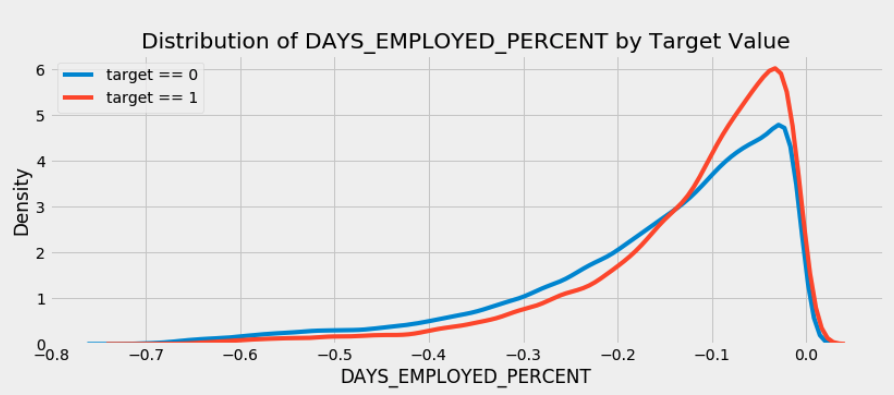

![](https://ws4.sinaimg.cn/large/006tKfTcgy1ft3p2xnp35j30po0cvq4l.jpg)

但毕竟领域的先验知识是有限的，我们有时候也没有足够的先验知识，同时自己进行特征组合也经常费时费力，自己生成的大量特征不是都有足够的重要性，还需要进一步筛选。

gplearn这个库提供了解决的思路：
- 随机化生成大量特征组合方式，解决了没有先验知识，手工生成特征费时费力的问题
- 通过遗传算法进行特征组合的迭代，而且这种迭代是有监督的迭代，存留的特征和label相关性是也来越高的，大量低相关特征组合会在迭代中被淘汰掉，用决策树算法做个类比的话，我们自己组合特征然后筛选，好比是后剪枝过程，遗传算法进行的则是预剪枝的方式。


变异的方式有兴趣的可以看看文档 [变异](http://gplearn.readthedocs.io/en/stable/intro.html#evolution)，具体遗传算法的方式我只是看看思路，并没有仔细推导。

官方给出的 [例子](http://gplearn.readthedocs.io/en/stable/examples.html#example-2-symbolic-transformer) 是用 sklearn中自带的波士顿房价数据来进行特征组合，但是只是给出了一个新生成的特征缺失提升了测试集的效果的结论。

所以，尝试还是用官方的数据，探索一下新生成的特征到底表现如何。

从一下几个方面考察：

- 特征和label的相关性
- 特征之间的共线性
- 特征在模型中的重要程度
- 特征对模型性能的提升



官方例子中，使用的是Ridge回归，使用 r2_score 评价回归效果。在生成10个特征后，0.7591提升至0.8417。

In [2]:
import numpy as np
import pandas as pd
np.random.seed(7)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

# 1 控制实验

In [3]:
def data_prepare():
    boston = load_boston()
    boston_feature = pd.DataFrame(boston.data, columns=boston.feature_names)
    boston_label = pd.Series(boston.target).to_frame("TARGET")

    boston = pd.concat([boston_label, boston_feature], axis=1)
    
    return boston

data = data_prepare()
print(data.shape)

(506, 14)


2 15


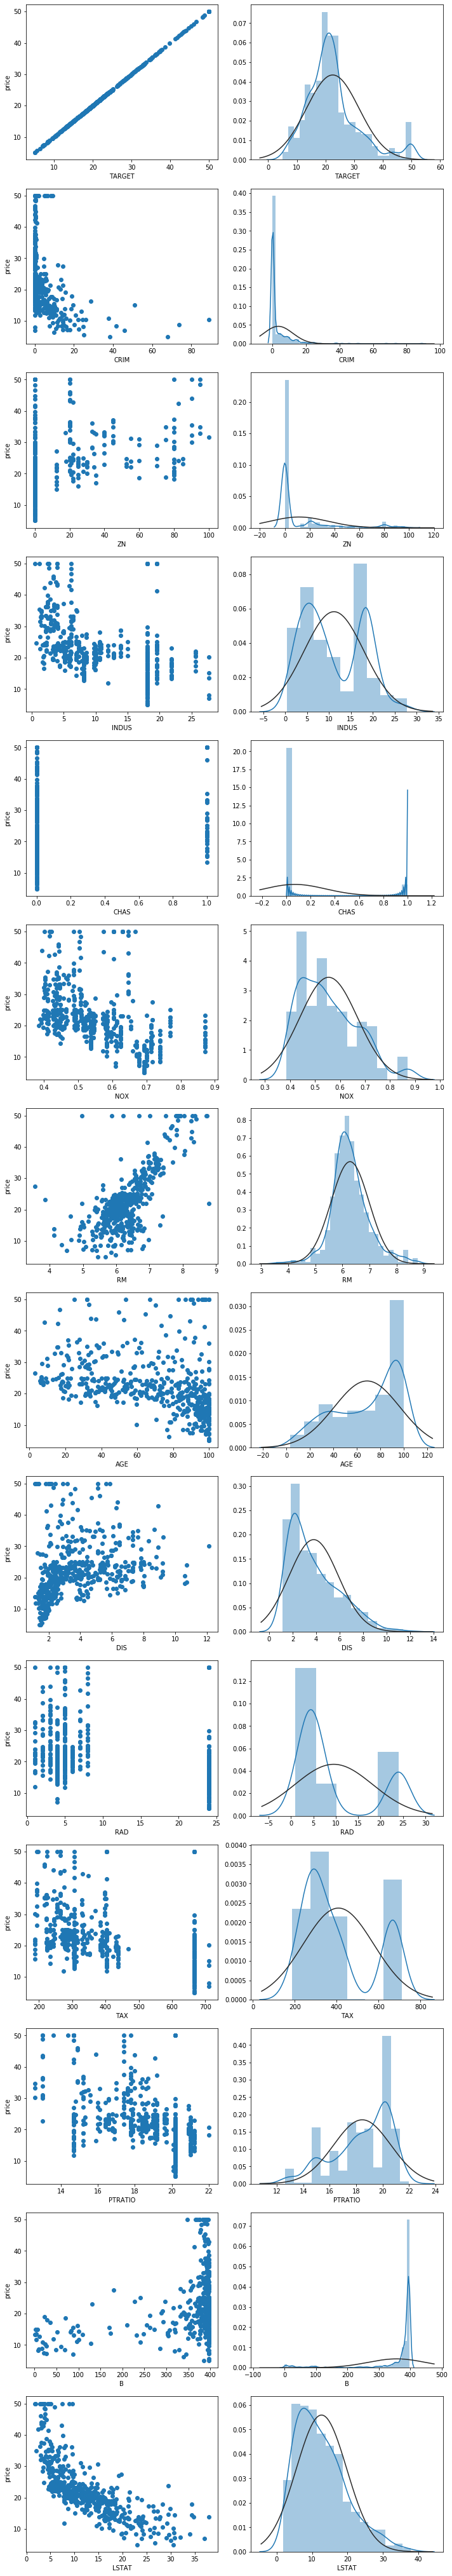

In [5]:
# 查看现有特征分布

def plot_dist(df, feature, pic_name='dist_plot.png'):
    fcols = 2
    frows = len(feature) + 1
    print(fcols, frows)
    plt.figure(figsize=(5*fcols, 4*frows))

    i = 0
    for col in feature:
        
        i += 1
        ax = plt.subplot(frows, fcols, i)

        plt.scatter(df[col], df['TARGET'])

        plt.xlabel(col)
        plt.ylabel('price')

        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(df[col].dropna(), fit=stats.norm)
        plt.xlabel(col)

    plt.tight_layout()
    
plot_dist(data, data.columns)

In [6]:
# 使用log1p变换将特征基本拉到一个尺度进行建模
for col in data.columns.drop('TARGET'):
    data[col] = np.log1p(data[col])

2 15


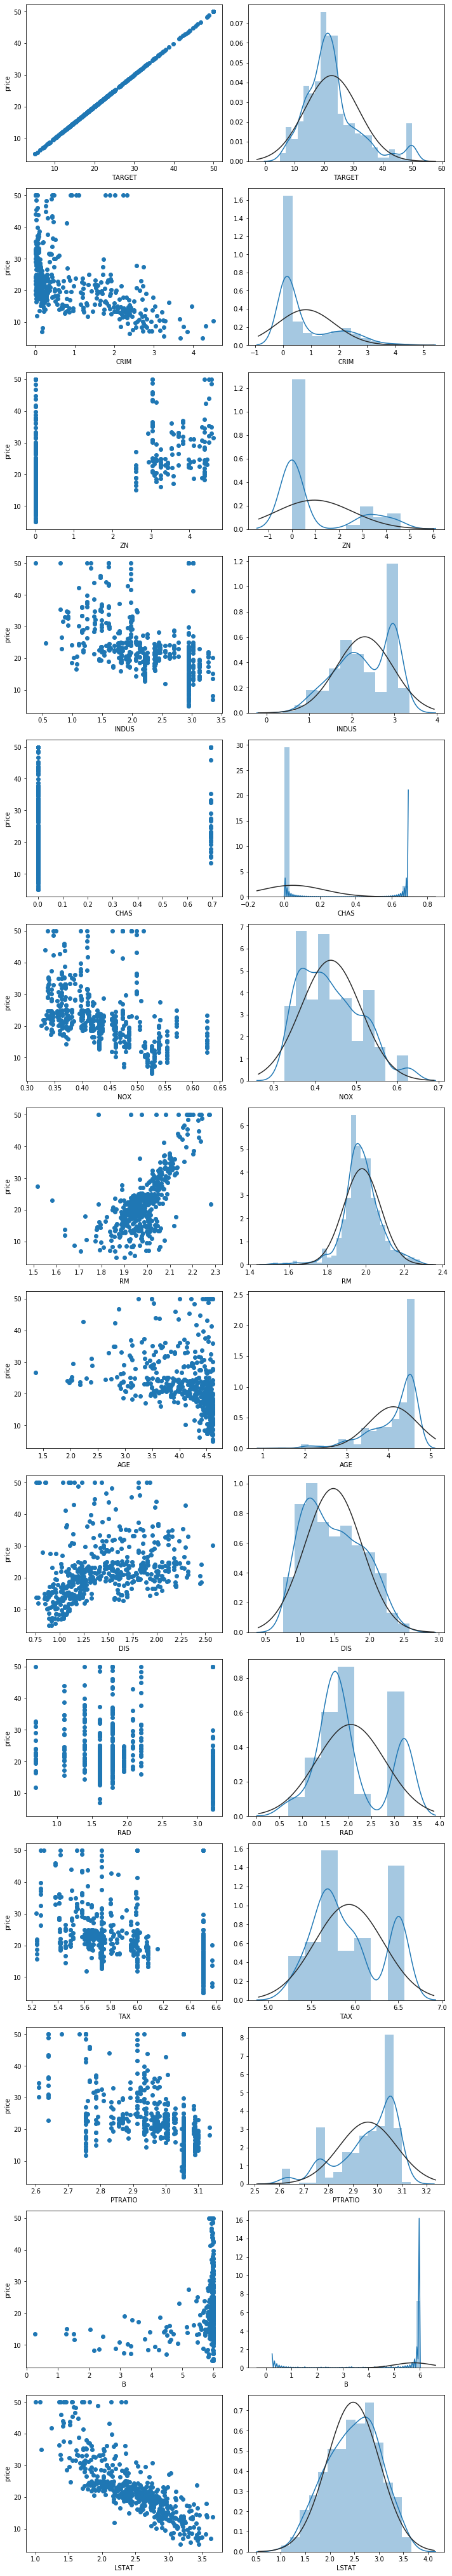

In [7]:
# 观察新的特征的分布
plot_dist(data, data.columns)

In [8]:
corr = data.corr('spearman')
corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
TARGET,1.000000,-0.558891,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914
CRIM,-0.558891,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,-0.360555,0.634760
ZN,0.438179,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074
INDUS,-0.578255,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747
CHAS,0.140612,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575
NOX,-0.562609,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828
RM,0.633576,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832
AGE,-0.547562,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071
DIS,0.445857,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262
RAD,-0.346776,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322


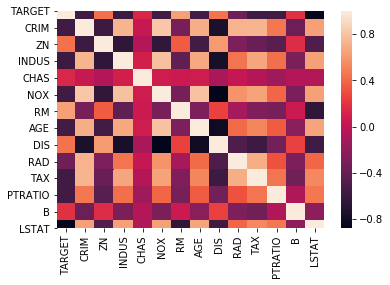

In [9]:
sns.heatmap(corr)

In [10]:
threshold = 0.85
correlated_pairs= {}
for col in corr:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corr.index[abs(corr[col]) > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [11]:
correlated_pairs

{'TARGET': ['LSTAT'],
 'CRIM': [],
 'ZN': [],
 'INDUS': [],
 'CHAS': [],
 'NOX': ['DIS'],
 'RM': [],
 'AGE': [],
 'DIS': ['NOX'],
 'RAD': [],
 'TAX': [],
 'PTRATIO': [],
 'B': [],
 'LSTAT': ['TARGET']}

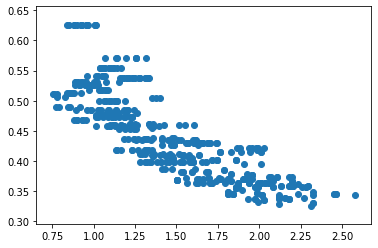

In [12]:
plt.scatter(data['DIS'], data['NOX'])

特征LSTAT 和 target 相关性较高， DIS 和 NOX 两个特征相关性较高,可视化展示一下

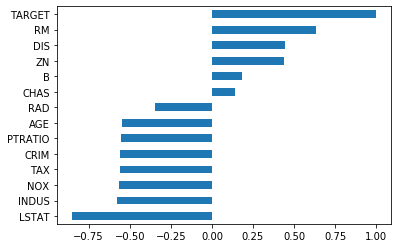

In [13]:
corr['TARGET'].sort_values().plot.barh()

## 原始特征的建模

In [14]:
features = data.columns.drop('TARGET') 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['TARGET'].to_frame(),
                                                        test_size=0.3, shuffle=True)

In [16]:
def Preds(x, y, x_test, y_test, alpha, n_splits=4, random_state=23, verbose=0):
    feature_importance = pd.DataFrame(columns=['feature', 'importance', 'fold'])

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds, sub_preds = np.zeros(x.shape[0]), np.zeros(x_test.shape[0])

    oof_train = np.zeros(x.shape[0])

    if verbose > 0:
        print(x.shape, x_test.shape)

    train_scores = []
    valid_scores = []
    test_scores = []


    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x, y)):
        trn_x, trn_y = x.iloc[trn_idx, :], y.iloc[trn_idx, :]
        val_x, val_y = x.iloc[val_idx, :], y.iloc[val_idx, :]

        # print(type(trn_x.values), type(trn_y.values), type(val_x.values), type(val_y.values))
        #
        # print(trn_x.shape, trn_y.shape)
        # print(val_x.shape, val_y.values.ravel().shape)

        model = Ridge(alpha=alpha) 
        model.fit(trn_x.values, trn_y.values.ravel())

        trn_preds = model.predict(trn_x)
        val_preds = model.predict(val_x)
        test_preds = model.predict(x_test)

        oof_preds[val_idx] = val_preds
        sub_preds += test_preds/folds.n_splits

        train_score = mean_squared_error(trn_y, trn_preds)
        val_score = mean_squared_error(val_y, val_preds)
        test_score = mean_squared_error(y_test, test_preds)

        train_scores.append(train_score)
        valid_scores.append(val_score)
        test_scores.append(test_score)

        feature_importance = feature_importance.append(pd.DataFrame({
            'importance': model.coef_,
            'fold': [n_fold + 1] * x.shape[1],
            'feature': x.columns.tolist()
        }))

  
    feature_importance['importance'] = feature_importance['importance'].astype(float)

    fi = feature_importance.groupby(['feature']).agg(['mean'])['importance'].sort_values(by=['mean'], ascending=False)

    fold_names = list(range(folds.n_splits))
    fold_names.append('overall')

    valid_mse = mean_squared_error(y, oof_preds)

    valid_scores.append(valid_mse)
    train_scores.append(np.mean(train_scores))
    test_scores.append(np.mean(test_scores))

    # 构建记录分数的 Dataframe
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores,
                            'test': test_scores})

    oof_preds = pd.Series(oof_preds.flatten(), index=x.index).rename('TARGET')
    sub_preds = pd.Series(sub_preds.flatten(), index=x_test.index).rename('TARGET')

    return metrics, fi

In [17]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train, y_train, x_test, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(x_train, y_train, x_test, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  18.864104  15.607442  20.610661
1        1  15.814994  24.232774  19.991547
2        2  17.177757  20.277304  18.726520
3        3  17.675552  18.206061  18.274392
4  overall  17.383102  19.582812  19.400780

0.005
      fold      train      valid       test
0        0  18.864486  15.582767  20.586877
1        1  15.815235  24.242050  19.978781
2        2  17.178118  20.277061  18.715476
3        3  17.675883  18.213485  18.264841
4  overall  17.383431  19.580725  19.386494

0.01
      fold      train      valid       test
0        0  18.865634  15.552992  20.557963
1        1  15.815957  24.253405  19.963094
2        2  17.179194  20.277742  18.702504
3        3  17.676872  18.223406  18.253631
4  overall  17.384414  19.578730  19.369298

0.05
      fold      train      valid       test
0        0  18.894710  15.349556  20.352260
1        1  15.834079  24.334397  19.845353
2        2  17.205614  20.312184  18.623052
3     

In [18]:
fi

,mean
feature,
RM,23.468831
CHAS,3.676937
RAD,3.002676
B,1.123515
AGE,0.345524
ZN,0.062442
INDUS,-1.045623
CRIM,-1.116932
TAX,-3.614236


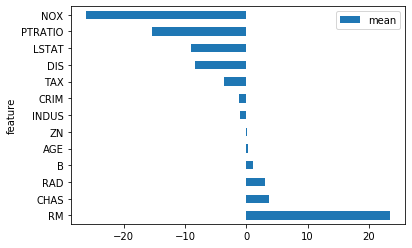

In [19]:
fi.plot.barh()

# 2 实验一

## 构建新特征

In [22]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']

gp1 = SymbolicTransformer(generations=10, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

train_idx = x_train.index
test_idx = x_test.index

gp1.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25         0.352558        4         0.839964          0.86314     21.98s
   1     7.74          0.65142        4         0.854811         0.613415     21.80s
   2     5.09         0.745207        6         0.865075         0.878227     20.97s
   3     7.03         0.751879        7         0.876343         0.795134     18.28s
   4     7.16          0.75918       10         0.882833         0.707373     15.43s
   5     7.81         0.759858       10         0.890308         0.596763     11.70s
   6     7.34         0.744429        8         0.893363         0.714507      8.52s
   7     7.39         0.755904        8         0.896596         0.696237      5.91s
   8     6.92         0.749452        8         0.893614         0.730238  

SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
                    function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt',
                                  'abs', 'neg', 'max', 'min'],
                    generations=10, hall_of_fame=100, init_depth=(2, 6),
                    init_method='half and half', low_memory=False,
                    max_samples=0.9, metric='pearson', n_components=10,
                    n_jobs=3, p_crossover=0.9, p_hoist_mutation=0.01,
                    p_point_mutation=0.01, p_point_replace=0.05,
                    p_subtree_mutation=0.01, parsimony_coefficient=0.0005,
                    population_size=1000, random_state=0, stopping_criteria=1.0,
                    tournament_size=20, verbose=1, warm_start=False)

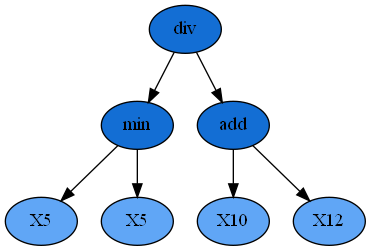

In [23]:
from IPython.display import Image
import pydotplus
graph = gp1._best_programs[0].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

可视化特征组合的方式，可以看到随机性是很强的，这个图示左子树其实没什么鸟用。。

In [24]:
gp_train_feature = gp1.transform(x_train)
gp_test_feature = gp1.transform(x_test)

new_feature_name = [str(i)+'V' for i in range(1, 11)]
train_new_feature = pd.DataFrame(gp_train_feature, columns=new_feature_name, index=train_idx)
test_new_feature = pd.DataFrame(gp_test_feature, columns=new_feature_name, index=test_idx)

In [25]:
x_train_0 = pd.concat([x_train, train_new_feature], axis=1)
x_test_0 = pd.concat([x_test, test_new_feature], axis=1)

new_x_data = pd.concat([x_train_0, x_test_0], axis=0)
new_data = pd.concat([data['TARGET'], new_x_data], axis=1)

In [26]:
new_data.columns

Index(['TARGET', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', '1V', '2V', '3V', '4V', '5V',
       '6V', '7V', '8V', '9V', '10V'],
      dtype='object')

### 新特征的分布

2 11


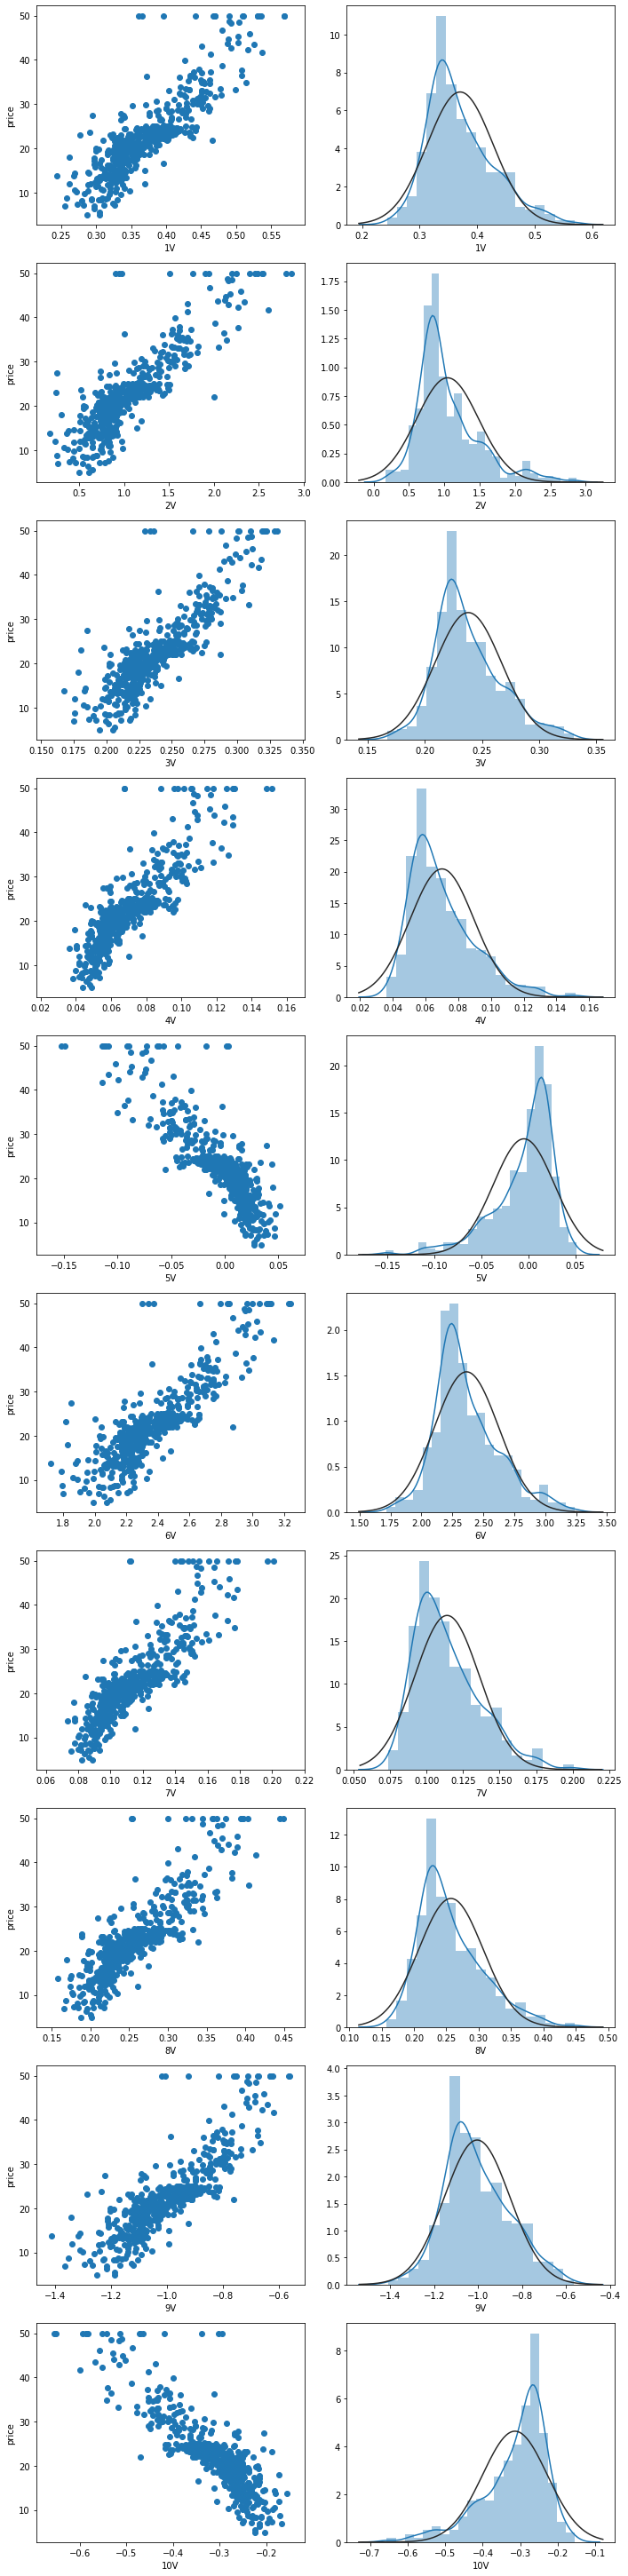

In [27]:
plot_dist(new_data, new_feature_name)

### 相关性

In [28]:
new_corr = new_data.corr('spearman')

In [29]:
new_corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
TARGET,1.000000,-0.558891,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914,0.860760,0.831370,0.851298,0.870853,-0.856905,0.841034,0.872339,0.860702,0.860760,-0.858390
CRIM,-0.558891,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,-0.360555,0.634760,-0.610137,-0.561100,-0.597124,-0.632636,0.606476,-0.575708,-0.638501,-0.615785,-0.610137,0.605036
ZN,0.438179,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074,0.515195,0.496038,0.519972,0.522433,-0.514665,0.502560,0.524323,0.506824,0.515195,-0.513073
INDUS,-0.578255,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747,-0.636452,-0.606435,-0.624598,-0.647182,0.634210,-0.617046,-0.649468,-0.639397,-0.636452,0.633855
CHAS,0.140612,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575,0.068970,0.063478,0.078355,0.070837,-0.066838,0.063532,0.070837,0.063105,0.068970,-0.068277
NOX,-0.562609,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828,-0.598750,-0.557065,-0.575474,-0.617590,0.596815,-0.570430,-0.622209,-0.610196,-0.598750,0.594549
RM,0.633576,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832,0.781473,0.864433,0.806493,0.720509,-0.788822,0.843991,0.696073,0.761261,0.781473,-0.792906
AGE,-0.547562,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071,-0.600422,-0.548232,-0.568915,-0.625786,0.597325,-0.564432,-0.632834,-0.617647,-0.600422,0.594566
DIS,0.445857,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262,0.531250,0.490094,0.509066,0.548261,-0.529366,0.502774,0.551673,0.542098,0.531250,-0.527314
RAD,-0.346776,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322,-0.364927,-0.315621,-0.354298,-0.390779,0.360011,-0.329203,-0.397841,-0.369379,-0.364927,0.358563


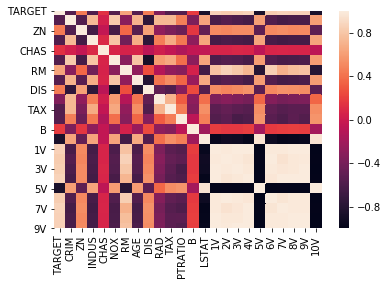

In [30]:
sns.heatmap(new_corr)

### 与标签的相关性

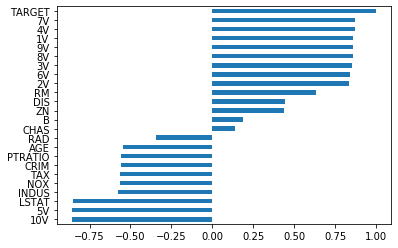

In [31]:
new_corr['TARGET'].sort_values().plot.barh()

新特征与label的相关性都很高

### 特征之间的相关性

In [32]:
new_features_corr = new_data[new_feature_name].corr('spearman')

In [33]:
new_features_corr

,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
1V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
2V,0.985936,1.000000,0.987176,0.963609,-0.988340,0.998843,0.952545,0.977956,0.985936,-0.989170
3V,0.992656,0.987176,1.000000,0.981191,-0.992998,0.991081,0.973690,0.980354,0.992656,-0.993462
4V,0.993647,0.963609,0.981191,1.000000,-0.991638,0.973799,0.998879,0.994279,0.993647,-0.991120
5V,-0.999698,-0.988340,-0.992998,-0.991638,1.000000,-0.993977,-0.985284,-0.996067,-0.999698,0.999801
6V,0.992173,0.998843,0.991081,0.973799,-0.993977,1.000000,0.964023,0.985442,0.992173,-0.994528
7V,0.987874,0.952545,0.973690,0.998879,-0.985284,0.964023,1.000000,0.989929,0.987874,-0.984604
8V,0.996708,0.977956,0.980354,0.994279,-0.996067,0.985442,0.989929,1.000000,0.996708,-0.995796
9V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
10V,-0.999694,-0.989170,-0.993462,-0.991120,0.999801,-0.994528,-0.984604,-0.995796,-0.999694,1.000000


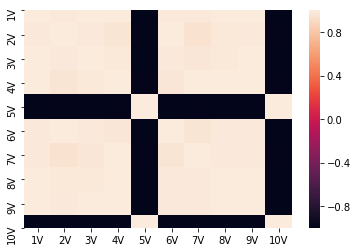

In [34]:
sns.heatmap(new_features_corr)

新特征之间的相关性很高, 都在0.95以上 

In [35]:
alphas = [1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.001最优
metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, 0.001)


0.0001
      fold      train      valid       test
0        0  13.369107  10.941365  20.916616
1        1  10.254286  20.316394  20.779509
2        2  11.705515  15.437983  19.312710
3        3  13.117187  11.309768  20.055182
4  overall  12.111524  14.507748  20.266004

0.0005
      fold      train      valid       test
0        0  13.572276  10.473539  20.043746
1        1  10.385401  20.016539  20.069536
2        2  11.841651  15.470250  18.757274
3        3  13.318386  10.846893  19.194573
4  overall  12.279429  14.207699  19.516282

0.001
      fold      train      valid       test
0        0  13.716057  10.333758  19.684615
1        1  10.478943  20.041603  19.755139
2        2  11.933584  15.526028  18.513257
3        3  13.495823  10.733577  18.809445
4  overall  12.406102  14.164555  19.190614

0.005
      fold      train      valid       test
0        0  14.120487  10.204860  19.145468
1        1  10.744437  20.253210  19.232593
2        2  12.240138  15.569626  18.023272
3 

In [36]:
fi

,mean
feature,
RM,85.282010
5V,81.978486
2V,39.592184
3V,9.525817
CHAS,3.186801
RAD,3.020320
1V,1.601744
B,0.824018
ZN,0.090928


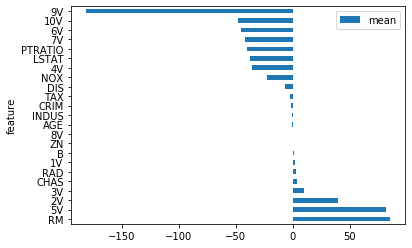

In [37]:
fi.plot.barh()

1 3 5 相对重要程度较小， 2 4 重要程度较高， 但是都没有超过原来的特征

In [38]:
metrics

,fold,train,valid,test
0,0,13.716057,10.333758,19.684615
1,1,10.478943,20.041603,19.755139
2,2,11.933584,15.526028,18.513257
3,3,13.495823,10.733577,18.809445
4,overall,12.406102,14.164555,19.190614


对比元特征训练的 mse分数，val 19.636047  test 19.362313 性能基本没变化

## 结论

在这个例子中，实际上模型效果没有提升，主要原因感觉是生成的特征属性较为单一，遗传算法最终的目标都是拟合label，导致特征之间相关性太高。

感觉可以适当降低遗传算法的轮数，保存特征的多样性，降低特征之间的相关性。

# 3 实验二

将遗传代数减低至一代进行模型构建

In [36]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']  # 

gp2 = SymbolicTransformer(generations=1, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

train_idx = x_train.index
test_idx = x_test.index

gp2.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25         0.352558        4         0.839964          0.86314      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt',
                                  'abs', 'neg', 'max', 'min'],
                    generations=1, max_samples=0.9, n_jobs=3,
                    parsimony_coefficient=0.0005, random_state=0, verbose=1)

In [37]:
print(gp2)

[log(add(X10, X12)),
 sub(div(0.767, min(X10, sub(X4, add(X12, X12)))), X5),
 min(X9, add(X7, X12)),
 max(sqrt(add(sqrt(X2), neg(X12))), neg(log(log(X11)))),
 div(X9, X5),
 mul(add(add(add(abs(X12), sqrt(X7)), div(mul(X2, X4), max(X11, X8))), div(sub(min(X0, X7), min(X11, X9)), max(sqrt(X7), sqrt(X8)))), max(min(min(sqrt(X3), div(X6, X9)), sub(sqrt(X9), log(X3))), max(sqrt(neg(-0.854)), sqrt(max(X1, X5))))),
 sub(max(0.518, X5), div(X4, X7)),
 mul(max(sqrt(sub(add(X7, X2), sqrt(X1))), add(neg(sub(X5, X0)), log(sqrt(X3)))), add(abs(min(sqrt(X6), log(X7))), add(sqrt(log(0.291)), sqrt(abs(X12))))),
 add(X10, X4),
 mul(abs(sub(log(X12), abs(X0))), sub(add(sub(X12, X1), min(X1, X5)), mul(div(X4, X10), sub(X5, X4))))]


In [38]:
gp_train_feature_1 = gp2.transform(x_train)
gp_test_feature_1 = gp2.transform(x_test)

new_feature_name_W = [str(i)+'W' for i in range(1, 11)]
train_new_feature_1 = pd.DataFrame(gp_train_feature_1, columns=new_feature_name_W, index=train_idx)
test_new_feature_1 = pd.DataFrame(gp_test_feature_1, columns=new_feature_name_W, index=test_idx)

2 11


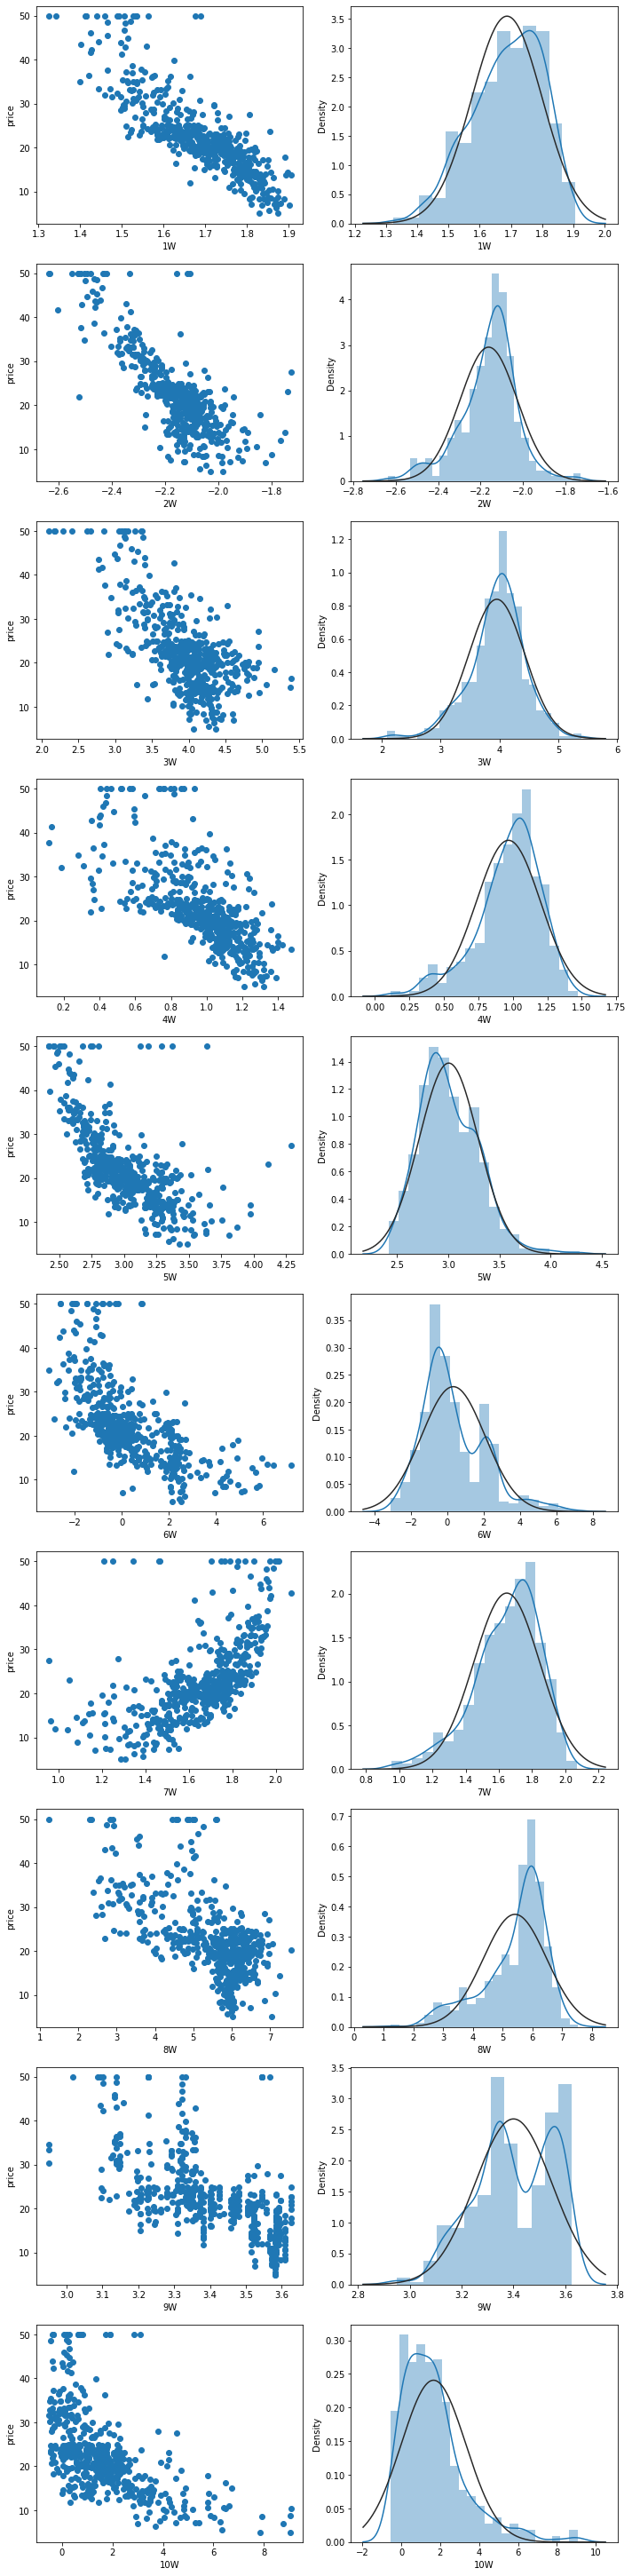

In [39]:
train_new_feature_1 = pd.concat([x_train, train_new_feature_1], axis=1)
test_new_feature_1 = pd.concat([x_test, test_new_feature_1], axis=1)

new_data_1 = pd.concat([train_new_feature_1, test_new_feature_1], axis=0)
new_data_1 = pd.concat([new_data_1, data['TARGET']], axis=1)

plot_dist(new_data_1, new_feature_name_W)

In [40]:
new_corr_1 = new_data_1.corr('spearman')

In [41]:
new_corr_1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,1W,2W,3W,4W,5W,6W,7W,8W,9W,10W,TARGET
CRIM,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,-0.360555,0.634760,0.646328,0.431792,0.104569,0.422408,0.722677,0.763430,-0.753270,0.456035,0.688024,0.603844,-0.558891
ZN,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074,-0.525903,-0.427051,-0.002462,-0.279212,-0.456032,-0.400874,0.627144,-0.725907,-0.593104,-0.671136,0.438179
INDUS,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747,0.648625,0.512054,0.079878,0.303114,0.698903,0.577586,-0.807914,0.583436,0.672561,0.599079,-0.578255
CHAS,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575,-0.069184,-0.058839,-0.110027,-0.079528,-0.060332,-0.013943,-0.017996,-0.017676,-0.047411,-0.017143,0.140612
NOX,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828,0.628623,0.436120,-0.027573,0.405013,0.664311,0.628243,-0.863321,0.387673,0.715402,0.590958,-0.562609
RM,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832,-0.638812,-0.962174,-0.531784,-0.580582,-0.642376,-0.499189,0.659321,-0.496719,-0.379275,-0.458434,0.633576
AGE,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071,0.643586,0.425247,0.074648,0.513164,0.538018,0.544219,-0.753003,0.307391,0.574308,0.567922,-0.547562
DIS,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262,-0.556126,-0.378336,0.202212,-0.356656,-0.581232,-0.451714,0.851416,-0.224907,-0.602163,-0.595261,0.445857
RAD,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322,0.411282,0.203925,0.044939,0.237892,0.623521,0.666089,-0.481738,0.194030,0.514125,0.484029,-0.346776
TAX,0.729045,-0.371394,0.664361,-0.044486,0.649527,-0.271898,0.526366,-0.574336,0.704876,1.000000,0.453345,-0.329843,0.534423,0.558187,0.371547,0.152904,0.351962,0.888386,0.668160,-0.639342,0.316588,0.640012,0.521644,-0.562411


<AxesSubplot:>

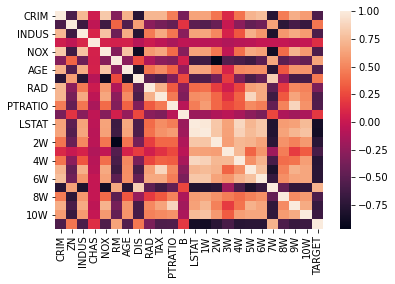

In [42]:
sns.heatmap(new_corr_1)

空值遗传1代(那不就是没有遗传) 这样的相关性才变低一点

In [43]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(train_new_feature_1, y_train, test_new_feature_1, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(train_new_feature_1, y_train, test_new_feature_1, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  13.083016  13.331728  17.130943
1        1  10.215035  26.428483  17.649131
2        2  12.350726  14.252829  16.171272
3        3  12.704204  12.980974  17.025689
4  overall  12.088245  16.766196  16.994259

0.005
      fold      train      valid       test
0        0  13.219887  12.445725  17.060925
1        1  10.237331  26.178499  17.559201
2        2  12.415464  14.220097  16.167731
3        3  12.740254  13.235791  16.946623
4  overall  12.153234  16.535802  16.933620

0.01
      fold      train      valid       test
0        0  13.407300  12.092479  17.150328
1        1  10.290645  25.742509  17.495256
2        2  12.531757  14.279814  16.177689
3        3  12.810834  13.485203  16.866630
4  overall  12.260134  16.414224  16.922476

0.05
      fold      train      valid       test
0        0  14.453832  12.427455  17.647436
1        1  11.046117  23.391319  17.559653
2        2  13.365719  15.188094  16.268624
3     

In [44]:
fi

,mean
feature,
RM,70.449735
5W,63.447126
4W,6.972644
PTRATIO,4.699264
B,2.902930
CHAS,2.723574
6W,2.250994
8W,2.159250
RAD,1.657117


In [45]:
metrics

,fold,train,valid,test
0,0,13.407300,12.092479,17.150328
1,1,10.290645,25.742509,17.495256
2,2,12.531757,14.279814,16.177689
3,3,12.810834,13.485203,16.866630
4,overall,12.260134,16.414224,16.922476


### 结论

| 实验名 |特征数量|验证集分数|测试集分数|
| :---: |:---: |:---: |:---: |
|控制组|13|19.636047  |19.362313|
|||||
|实验一|23| 14.220659  |19.142288|
|||||
|实验二|23|16.628614	|16.854483|

实验一 和 实验二分别只是调整了遗传算法的训练代数，实验一训练了三代，生成的特征与目标相关性高，但是特征之间的相关性也很高，实验二只训练了一代其实就是没有进行遗传迭代，虽然生成的特征与目标相关性不强，但是生成的特征具有更高的复杂性，反而在更好的提升了模型的性能。

所以可以两个策略，一种是训练多代，输出少量特征；另一种是不进行遗传迭代，随机产生大量特征，综合两种特征进行建模。

所以实验三中，综合前两个实验gplearn模型生成特征的方式，看是否有模型提升效果。

# 4 实验三

In [46]:
# 新构建 符号转换对象 
gp3 = SymbolicTransformer(generations=1, population_size=1000, # 增加随机生成特征的种类
                         hall_of_fame=100, n_components=10,    # 同时增加筛选出来的特征数量
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

gp3.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25         0.352558        4         0.839964          0.86314      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt',
                                  'abs', 'neg', 'max', 'min'],
                    generations=1, max_samples=0.9, n_jobs=3,
                    parsimony_coefficient=0.0005, random_state=0, verbose=1)

In [47]:
print(gp3)

[log(add(X10, X12)),
 sub(div(0.767, min(X10, sub(X4, add(X12, X12)))), X5),
 min(X9, add(X7, X12)),
 max(sqrt(add(sqrt(X2), neg(X12))), neg(log(log(X11)))),
 div(X9, X5),
 mul(add(add(add(abs(X12), sqrt(X7)), div(mul(X2, X4), max(X11, X8))), div(sub(min(X0, X7), min(X11, X9)), max(sqrt(X7), sqrt(X8)))), max(min(min(sqrt(X3), div(X6, X9)), sub(sqrt(X9), log(X3))), max(sqrt(neg(-0.854)), sqrt(max(X1, X5))))),
 sub(max(0.518, X5), div(X4, X7)),
 mul(max(sqrt(sub(add(X7, X2), sqrt(X1))), add(neg(sub(X5, X0)), log(sqrt(X3)))), add(abs(min(sqrt(X6), log(X7))), add(sqrt(log(0.291)), sqrt(abs(X12))))),
 add(X10, X4),
 mul(abs(sub(log(X12), abs(X0))), sub(add(sub(X12, X1), min(X1, X5)), mul(div(X4, X10), sub(X5, X4))))]


In [48]:
gp4 = SymbolicTransformer(generations=3, population_size=1000, 
                         hall_of_fame=100, n_components=1,    # 生成特征生成减少到2
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

gp4.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25         0.352558        4         0.839964          0.86314      0.51s
   1     7.74          0.65142        4         0.854811         0.613415      0.31s
   2     5.09         0.745207        6         0.865075         0.878227      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt',
                                  'abs', 'neg', 'max', 'min'],
                    generations=3, max_samples=0.9, n_components=1, n_jobs=3,
                    parsimony_coefficient=0.0005, random_state=0, verbose=1)

In [49]:
gp_train_feature_3 = gp3.transform(x_train)
gp_test_feature_3 = gp3.transform(x_test)

new_feature_name_M = [str(i)+'M' for i in range(1, 11)]
train_new_feature_3 = pd.DataFrame(gp_train_feature_3, columns=new_feature_name_M, index=train_idx)
test_new_feature_3 = pd.DataFrame(gp_test_feature_3, columns=new_feature_name_M, index=test_idx)

In [50]:
gp_train_feature_4 = gp4.transform(x_train)
gp_test_feature_4 = gp4.transform(x_test)

new_feature_name_N = [str(i)+'N' for i in range(1, 2)]
train_new_feature_4 = pd.DataFrame(gp_train_feature_4, columns=new_feature_name_N, index=train_idx)
test_new_feature_4 = pd.DataFrame(gp_test_feature_4, columns=new_feature_name_N, index=test_idx)

(354, 24)
2 12


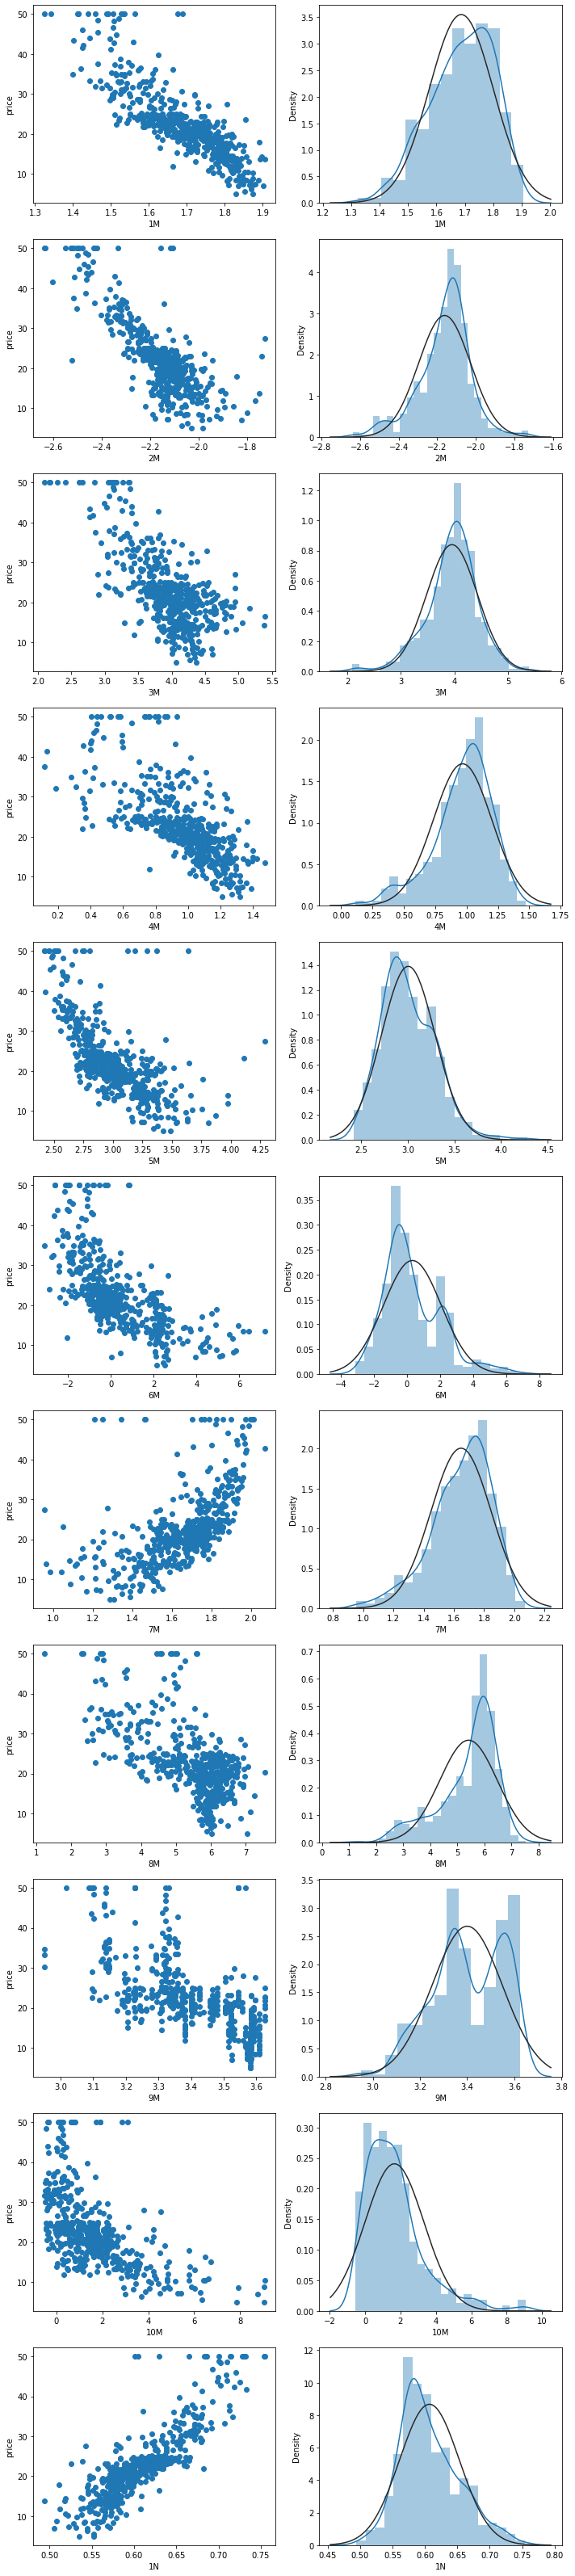

In [51]:
train_new_feature_34 = pd.concat([x_train, train_new_feature_3, train_new_feature_4], axis=1)
test_new_feature_34 = pd.concat([x_test, test_new_feature_3, test_new_feature_4], axis=1)

print(train_new_feature_34.shape)

new_data_34 = pd.concat([train_new_feature_34, test_new_feature_34], axis=0)
new_data_34 = pd.concat([new_data_34, data['TARGET']], axis=1)

features_34 = new_feature_name_M + new_feature_name_N

plot_dist(new_data_34, new_feature_name_M + new_feature_name_N)

In [52]:
corr_34 = new_data_34[new_feature_name_M + new_feature_name_N + ['TARGET']].corr('spearman')

In [53]:
corr_34

,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,1N,TARGET
1M,1.000000,0.801092,0.630303,0.869145,0.747582,0.812240,-0.783988,0.637961,0.726987,0.785747,-0.969454,-0.869807
2M,0.801092,1.000000,0.609169,0.736713,0.711906,0.638680,-0.746010,0.559808,0.480009,0.588304,-0.907086,-0.745088
3M,0.630303,0.609169,1.000000,0.744363,0.357113,0.576175,-0.180705,0.470488,0.199736,0.330272,-0.630063,-0.593618
4M,0.869145,0.736713,0.744363,1.000000,0.549883,0.709339,-0.587493,0.400340,0.421000,0.612120,-0.847173,-0.751406
5M,0.747582,0.711906,0.357113,0.549883,1.000000,0.780747,-0.816003,0.485207,0.702986,0.648017,-0.779370,-0.741520
6M,0.812240,0.638680,0.576175,0.709339,0.780747,1.000000,-0.680950,0.541657,0.642593,0.650413,-0.783659,-0.742078
7M,-0.783988,-0.746010,-0.180705,-0.587493,-0.816003,-0.680950,1.000000,-0.462278,-0.715611,-0.704140,0.815749,0.715780
8M,0.637961,0.559808,0.470488,0.400340,0.485207,0.541657,-0.462278,1.000000,0.526883,0.596782,-0.627915,-0.566844
9M,0.726987,0.480009,0.199736,0.421000,0.702986,0.642593,-0.715611,0.526883,1.000000,0.675907,-0.690319,-0.675513
10M,0.785747,0.588304,0.330272,0.612120,0.648017,0.650413,-0.704140,0.596782,0.675907,1.000000,-0.746662,-0.653291


<AxesSubplot:>

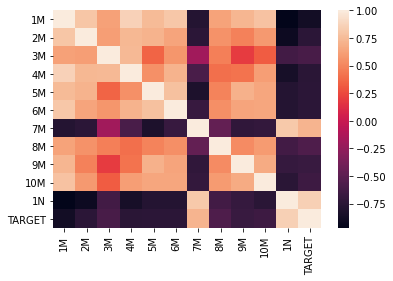

In [54]:
sns.heatmap(corr_34)

In [55]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(train_new_feature_34, y_train, test_new_feature_34, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(train_new_feature_34, y_train, test_new_feature_34, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  13.046173  13.146739  17.103811
1        1  10.171257  25.880322  17.599052
2        2  12.222055  14.253003  16.057634
3        3  12.667651  12.846128  16.957691
4  overall  12.026784  16.548395  16.929547

0.005
      fold      train      valid       test
0        0  13.212134  12.392044  17.052022
1        1  10.221278  26.022104  17.533496
2        2  12.377186  14.211035  16.125898
3        3  12.727931  13.187557  16.919394
4  overall  12.134632  16.468744  16.907702

0.01
      fold      train      valid       test
0        0  13.401289  12.060143  17.147719
1        1  10.277126  25.685254  17.473979
2        2  12.507365  14.268090  16.153696
3        3  12.801840  13.449118  16.849802
4  overall  12.246905  16.379815  16.906299

0.05
      fold      train      valid       test
0        0  14.435504  12.409587  17.652973
1        1  11.017798  23.417880  17.538358
2        2  13.344658  15.158864  16.263632
3     

In [56]:
metrics

,fold,train,valid,test
0,0,13.401289,12.060143,17.147719
1,1,10.277126,25.685254,17.473979
2,2,12.507365,14.268090,16.153696
3,3,12.801840,13.449118,16.849802
4,overall,12.246905,16.379815,16.906299


In [57]:
fi

,mean
feature,
RM,69.770744
5M,63.151824
1N,20.196419
4M,7.049612
PTRATIO,5.150906
B,2.925762
CHAS,2.715293
1M,2.365457
6M,2.280820


### 结论

| 实验名 |特征数量|验证集分数|测试集分数|
| :---: |:---: |:---: |:---: |
|控制组|13|19.636047  |19.362313|
|||||
|实验一|23| 14.220659  |19.142288|
|||||
|实验二|23|16.628614	|16.854483|
|||||
|实验三|24|16.598239	|16.837614|

性能稍微提升了一点，当然还可以继续增加生成的特征数量看看能不能继续提升，这里就不再继续了。


当然后续还有空值gplearn模型复杂的的操作方式，这里就没有继续研究了，设想一下，如果控制了生成公式的复杂程度，是可以适当提升一下遗传迭代的层数来生成一些保存了多样性的特征的。